In [1]:
import numpy as np
import math
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
from odlib import *
import time
from astropy.io import fits
from matplotlib.lines import Line2D

In [53]:
class OD:
    '''Class that performs all orbital determination calculations'''
    
    def __init__(self, inputFile:str):
        """ Initializes OD class
            Args:
                inputFile (str): input file name
            Returns:
                None
        """
        # constants
        self.k = 0.0172020989484 #Gaussian gravitational constant  
        self.cAU = 173.144643267 #speed of light in au/(mean solar)day  
        self.mu = 1
        self.eps = np.radians(23.4374) #Earth's obliquity
        self.toGaussian=365.2568983
        self.mu = 1
        
        self.data=Data() # Data object
        self.inputFile=inputFile
        
    def genElements(self, pos:list, vel:list, time:float, update:bool=True):
        """ Calculates and returns the orbital elements given position, velocity, time
            Args:
                pos (list): the position vector
                vel (list): the velocity vector
                time (float): the time in Julian days
                update (bool): if True keeps the newly calculated orbital elements
            Returns:
                floats: the orbital elements; a,e,i,o,v,w,T,M
        """
        if update:
            self.pos,self.vel,self.time=pos,vel,time
            self.od=ODElements(self.pos,self.vel,self.time)
            self.a,self.e,self.i,self.o,self.v,self.w,self.T,self.M = self.od.getElements()
            return self.getElements()
        else:
            od=ODElements(pos,vel,time)
            return od.getElements()
    
    def getElements(self):
        """ Returns the orbital elements (already calculated)
            Args:
                rad (bool): True if return in radians
            Returns:
                floats: a,e,i,o,v,w,T,M
        """
        return self.a, self.e, self.i, self.o, self.v, self.w, self.T, self.M
    
    def SEL(self, taus:list, sunR2:list, rhohat2:list, coefD:list):
        """ Scalar Equation of Lagrange to calculate the roots (r) and rhos corresponding to each r
            Args:
                taus (list): a list of floats of taus [T1,T3,T]
                sunR2 (list): a list representing the sun vector R2
                rhohat2 (list): a list representing the rhohat2 vector
                coefD (list): a list of D coefficients [D0,D21,D22,D23]
            Returns:
                lists: roots (r's), rhos
        """
        T1,T3,T=taus[0],taus[1],taus[2]
        D0,D21,D22,D23=coefD[0],coefD[1],coefD[2],coefD[3]
        A1=T3/T
        B1=A1/6*(T**2-T3**2)
        A3=-T1/T
        B3=A3/6*(T**2-T1**2)
        A=(A1*D21-D22+A3*D23)/(-D0)
        B=(B1*D21+B3*D23)/(-D0)
        
        E=-2*(dot(rhohat2, sunR2))
        F=dot(sunR2,sunR2)
        
        a=-(A**2+A*E+F)
        b=-self.mu*(2*A*B+B*E)
        c=-self.mu**2*B**2
        
        coef=[c,0,0,b,0,0,a,0,1]
        res=poly.polyroots(coef)

        temproots=[]
        for val in res: 
            if np.isreal(val) and np.real(val)>0: temproots.append(np.real(val))

        temprhos=[A+B/temproots[i]**3 for i in range(len(temproots))]
        
        # ignore pairs where rho magnitude is negative
        roots=[]
        rhos=[]
        #print(temproots, temprhos)
        for i in range(len(temproots)):
            if temprhos[i]>0.0:
                roots.append(temproots[i])
                rhos.append(temprhos[i])
                
        
        
        return roots,rhos
    
    def ephemeris(self, time:float, date:str, file:str="", sunPos:list=np.array([])):
        """ Calculates RA and Dec given time and date, using previously calculated orbital elements
            Args:
                time (float): time to determine ephemeris for in Julian Days
                date (str): date for which to determine ephemeris
                file (str): file name for sun positions; optional
            Returns:
                floats: ra, dec
        """
        n=self.k*math.sqrt(self.mu/(self.a**3))
        M=n*(time-self.T)
        E=newton(lambda E:M - E + self.e*np.sin(E), lambda E: -1+self.e*np.cos(E), M, 1e-17)
        
        pos=np.array([self.a*math.cos(E)-self.a*self.e, self.a*math.sqrt(1-self.e**2)*math.sin(E), 0])
        
        # the four rotations
        pos=rotZX(pos,np.deg2rad(self.w),np.deg2rad(self.i))
        pos=rotZX(pos,np.deg2rad(self.o),self.eps)
        
        if file=="": # no file given, use sunPos
            R=sunPos
        else: R=self.data.getSunPos(date, file)
        if np.array_equal(R, np.array([0,0,0])): raise Exception("Sun Position Not Found in SunPos.txt")
        rho=pos+R
        rhohat=rho/getMag(rho)
        
        dec=math.asin(rhohat[2])
        cra=rhohat[0]/math.cos(dec)
        sra=rhohat[1]/math.cos(dec)

        ra=getAngle(sra,cra)
        
        dec=np.rad2deg(dec)
        ra=np.rad2deg(ra)
        
        dec=DECdecimalToDMS(dec)
        ra=RAdecimalToHMS(ra)
        
        return ra,dec
        
        
    def fg(self, tau:float, r2mag:float, r2dot:list, order:int, r2:list=[]):
        """ Gets the f and g values given one time
            Args:
                tau (float): the time in Julian Days
                r2mag (float): the magnitude of r2
                r2dot (list): the velocity vector 2
                order (int): order of f and g taylor series approximations
                r2 (list): optional parameter, the position vector 2
            Returns:
                floats: f, g
        """
        if len(r2)==0: u=self.mu/r2mag**3
        else: u=self.mu/getMag(r2)**3
        
        f=1-1/2*u*tau**2
        g=tau
        
        if order>=3:
            z=dot(r2,r2dot)/(dot(r2,r2))
            q=dot(r2dot,r2dot)/(dot(r2,r2))-u
            f+=1/2*u*z*tau**3
            g+=-1/6*u*tau**3
        
        if order>=4:
            f+=1/24*(3*u*q-15*u*z**2+u**2)*tau**4
            g+=1/4*u*z*tau**4
        
        return f, g
        
    def getFGVals(self, tau1:float, tau3:float, r2mag:float, r2dot:list, order1:int, order2:int, r2:list=[]):
        """ Gets all f and g values
            Args:
                tau1 (float): the time in Julian Days for observation 1 from obs 2(T1-T2)
                tau3 (float): the time in Julian days for observation 3 from obs 2(T3-T2)
                r2mag (float): the magnitude of r2
                r2dot (list): the velocity vector 2
                order1 (int): Order of Taylor Series expansion for f and g values for observation 1
                order2 (int): Order of Taylor Series expansion for f and g values for observation 3
                r2 (list): optional parameter, the position vector 2
            Returns:
                lists: [f1,f3], [g1,g3]
        """
        f1,g1=self.fg(tau1,r2mag,r2dot,order1,r2)
        f3,g3=self.fg(tau3,r2mag,r2dot,order2,r2)
        return [f1,f3], [g1,g3]
    
    def getDCoef(self, ra:list, dec:list, R1:list, R2:list, R3:list):
        """ Gets the D coefficients given the ra and dec for three observations (in radians)
            Args:
                ra (list): the right ascensions for three observations (radians)
                dec (list): the declinations for three observations (radians)
                R1 (list): the sun vector for observation 1
                R2 (list): the sun vector for observation 2
                R3 (list): the sun vector for observation 3
            Returns:
                list: [D0,D11,D12,D13,D21,D22,D23,D31,D32,D33], [rhohat1, rhohat2, rhohat3]
        """
        ra1,ra2,ra3=ra[0],ra[1],ra[2]
        dec1,dec2,dec3=dec[0],dec[1],dec[2]
        
        rhohat1=np.array([np.cos(ra1)*np.cos(dec1), np.sin(ra1)*np.cos(dec1), np.sin(dec1)])
        rhohat2=np.array([np.cos(ra2)*np.cos(dec2), np.sin(ra2)*np.cos(dec2), np.sin(dec2)])
        rhohat3=np.array([np.cos(ra3)*np.cos(dec3), np.sin(ra3)*np.cos(dec3), np.sin(dec3)])
        
        D0=dot(rhohat1, cross(rhohat2,rhohat3))
        D11=dot(cross(R1, rhohat2),rhohat3)
        D12=dot(cross(R2, rhohat2),rhohat3)
        D13=dot(cross(R3, rhohat2),rhohat3)
        
        D21=dot(cross(rhohat1,R1), rhohat3)
        D22=dot(cross(rhohat1,R2), rhohat3)
        D23=dot(cross(rhohat1,R3), rhohat3)
        
        D31=dot(rhohat1, cross(rhohat2,R1))
        D32=dot(rhohat1, cross(rhohat2,R2))
        D33=dot(rhohat1, cross(rhohat2,R3))
     
        return [D0,D11,D12,D13,D21,D22,D23,D31,D32,D33], np.array([rhohat1, rhohat2, rhohat3])
    
    def MoGGenData(self,loaded:bool,selTime:list=[],selDate:list=[],ra:list=[],dec:list=[]):
        """ Generates the data for Method of Gauss calculations
            Args:
                loaded (bool): True if data is already loaded
                selTime (list): list of chosen times (in Julian days) for observations 1,2,3
                selDate (list): list of chosen datesfor observations 1,2,3
                ra (list): list of right ascensions
                dec (list): list of declinations
            Returns:
                lists: ra, dec, R1, R2, R3, taus, ts (original times in Julian days)
        """
        if not loaded:
            self.data.getInput(self.inputFile) # formats and generates info
            # generate data
            if not(selTime==[]): # using Julian day times
                if ra==[] and dec==[]:
                    ra,dec=[],[]
                    for time in selTime:
                        r,d=self.data.getRADECInput(time=time)
                        ra.append(np.deg2rad(r))
                        dec.append(np.deg2rad(d))
                R1=self.data.getSunInput(time=selTime[0])
                R2=self.data.getSunInput(time=selTime[1])
                R3=self.data.getSunInput(time=selTime[2])
                # calculate the taus
                t1,t2,t3=selTime[0],selTime[1],selTime[2]
                ts=[t1,t2,t3]
                T1=t1-t2
                T3=t3-t2
                T=t3-t1
                taus = [T1,T3,T] # in Gaussian days

            elif not(selDate==[]):
                if ra==[] and dec==[]:
                    ra,dec=[],[]
                    for date in selDate:
                        r,d=self.data.getRADECInput(date=date)
                        ra.append(np.deg2rad(r))
                        dec.append(np.deg2rad(d))
                R1=self.data.getSunInput(date=selDate[0])
                R2=self.data.getSunInput(date=selDate[1])
                R3=self.data.getSunInput(date=selDate[2])
                # calculate the taus given the dates
                t1,t2,t3=self.data.getJDTime(selDate[0]),self.data.getJDTime(selDate[1]),self.data.getJDTime(selDate[2])
                ts=[t1,t2,t3]
                T1=t1-t2
                T3=t3-t2
                T=t3-t1
                taus = [T1*self.k,T3*self.k,T*self.k]

            else: raise Exception("No data given")
            self.loadedValues=[ra,dec,np.array(R1),np.array(R2),np.array(R3),taus,np.array(ts)]
        else:
            if not(ra==[] and dec==[]):
                self.loadedValues[0] = ra
                self.loadedValues[1] = dec
        return self.loadedValues
    
    def MoGCalcRhos(self, rhohats:list, coefD:list, fvals:list, gvals:list):
        """ Generates the rhos (and their magnitudes) for Method of Gauss calculations
            Args:
                rhohats (list): the direction vectors for rhos
                coefD (list): the D coefficients
                fvals (list): the f values
                gvals (list): the g values
            Returns:
                lists: rhos, rhomags
        """
        f1,f3=fvals
        g1,g3=gvals
        D0,D11,D12,D13,D21,D22,D23,D31,D32,D33=coefD
        C1=g3/(f1*g3-g1*f3)
        C2=-1
        C3=-g1/(f1*g3-g1*f3)
        rho1=(C1*D11+C2*D12+C3*D13)/(C1*D0)
        rho2=(C1*D21+C2*D22+C3*D23)/(C2*D0)
        rho3=(C1*D31+C2*D32+C3*D33)/(C3*D0)
        rhomags=np.array([rho1,rho2,rho3])
        rhos=np.array([rhohats[0]*rho1, rhohats[1]*rho2, rhohats[2]*rho3])
        return rhos, rhomags
    
    def MoGCalcPos(self, rhos:list, Rs:list)->list:    
        """ Calculates the r vectors (position of asteroid from sun) for Method of Gauss calculations
            Args:
                rhos (list): the position from Earth vectors
                Rs (list): the position from Sun vectors
            Returns:
                lists: rs
        """
        return rhos-Rs
        
    def MoGGetErr(self, prev:list, cur:list, tolerance:float)->bool:
        """ Calculates the r vectors (position of asteroid from sun) for Method of Gauss calculations
            Args:
                prev (list): previous r vector
                cur (list): the newly calculated r vector
                tolerance (float): the tolerance
            Returns:
                bool: True if error is good, False if no within tolerance
        """
        for i in range(len(prev)):
            if abs(prev[i]-cur[i])>tolerance: return False
        return True
    
    def MoGGetAdjustedTaus(self, origt:list, rhomags:float)->list:
        """ Returns adjusted taus for Method of Gauss calculations
            Args:
                origt (list): original observation times in Julian days
                rhomags (list): the magnitude of the rho vectors
            Returns:
                list: the adjusted taus
        """
        ts=np.copy(origt)-rhomags/self.cAU
        t1,t2,t3=ts
        return [(t1-t2)*self.k,(t3-t2)*self.k,(t3-t1)*self.k]
    
    def MoG(self,selTime:list=[],selDate:list=[],override:bool=True,ra:list=[],dec:list=[],loaded:bool=False):
        """ Performs Method of Gauss calculations to determine orbital elements
            Args:
                selTime (list): list of chosen times (in Julian days) for observations 1,2,3
                selDate (list): list of chosen datesfor observations 1,2,3
                override (bool): boolean, True if override info
                ra (list): optional list of right ascensions
                dec (list): optional list of declinations
                loaded (bool): optional, True if all data is already loaded (speeds up run time)
            Returns:
                None
        """
        # generate data
        ra,dec,R1,R2,R3,taus,ts=self.MoGGenData(False,selTime,selDate,ra,dec)
        
        # calculate the initial estimate for r2 DONE
        coefD,rhohats=self.getDCoef(ra, dec, R1, R2, R3)

        SELcoefD=[coefD[0],coefD[4],coefD[5],coefD[6]] # [D0,D11,D12,D13,D21,D22,D23,D31,D32,D33] -> [D0,D21,D22,D23]
        r2MagGuesses,rhoMagGuesses=self.SEL(taus, R2, rhohats[1], SELcoefD)
        
        results=[]
        
        # calculate the f and g values to second order
        for r2mag in r2MagGuesses:
            # initial guesses
            fvals,gvals=self.getFGVals(taus[0], taus[1], r2mag, [], 2, 2) # using r2mag
            rhos,rhomags=self.MoGCalcRhos(rhohats, coefD, fvals, gvals)
            rs=self.MoGCalcPos(rhos, np.array([R1,R2,R3]))
   
            # calculate the central velocity vector
            f1,f3=fvals
            g1,g3=gvals
            r2dot = (-f3/(-f3*g1+g3*f1))*rs[0] + (f1/(f1*g3-f3*g1))*rs[2]
            counter=0
            timedOut=True
            timeout=time.time() + 60*3 # timeout after 3 minutes
            
            while counter<5000 and time.time()<timeout: # timeout
                prev=rs[1]
                
                # time adjustment
                newtaus=self.MoGGetAdjustedTaus(ts, rhomags)
                
                fvals,gvals=self.getFGVals(newtaus[0], newtaus[1], r2mag, r2dot, 4, 4, rs[1]) # using r2mag
                rhos,rhomags=self.MoGCalcRhos(rhohats, coefD, fvals, gvals)
                rs=self.MoGCalcPos(rhos, np.array([R1,R2,R3]))
                
                f1,f3=fvals
                g1,g3=gvals
                r2dot = (-f3/(-f3*g1+g3*f1))*rs[0] + (f1/(f1*g3-f3*g1))*rs[2]
                
                counter+=1
                
                if (self.MoGGetErr(prev, rs[1], 1e-23)): 
                    timedOut=False
                    break
            
            if not timedOut:
                # rotate around x axis to get to ecliptic
                r2=rotX(np.array(rs[1]),-self.eps)
                r2dot=rotX(r2dot,-self.eps)
                rho2=rotX(rhos[1],-self.eps)
                results.append([r2, r2dot, rho2]) # position and velocity
        
        resIndex=0
        if len(results)>1: # get user input to choose which result to use 
            for i in range(len(results)):
                print("Result",str(i)+":")
                print("\tPos from Sun:",r2,"\n\tVel:",r2dot,"\n\tPos from Earth:",rho2,"\n")

            while True:
                try: 
                    resIndex=int(input("Choose which result to use (int): "))
                    if not(0<=resIndex<len(results)): resIndex/=0 # throw an error
                    break
                except:
                    print("Enter a valid integer")
        
        if len(results)==0: return False, 0, 0, 0, 0, 0, 0
            
        # get final answers
        pos,vel,rho=results[resIndex]
        
        if override:
            self.genElements(pos,np.array(vel)*(2*math.pi)/365.2568983,ts[1])
            self.vel = vel
            self.pos = pos
            self.rho = rho
        else:
            a,e,i,o,v,w,T,M=self.genElements(pos,np.array(vel)*(2*math.pi)/365.2568983,ts[1], update=False)
            return True, a,e,i,o,w,T
        
    def getError(self, results:list):
        """ Prints error and results from orbital elements determination after Method of Gauss calculations
            Args:
                results (list): [e,0,i,o,w,T,0,0,0,a]
            Returns:
                None
        """
        # adjust time of perihelion from results to match period of calculated time of perihelion
        period=results[9]**(3/2)*self.toGaussian
        results[5]=self.time-((self.time-results[5])%period) # subtract the change in time since the last perihelion from the obs 2 time 
        self.od.printError(results)
        
    def exportResults(self, time:float, date:str, fileName:str):
        """ Exports results to a file
            Args:
                time (float): time in Julian days for the Mean Anomaly
                date (str): date for Mean Anomaly
                fileName (str): the exported file name
            Returns:
                None
        """
        M=self.od.getTimeMeanAnomaly(time, date)
        self.data.printResults(fileName, self.pos, self.vel/self.toGaussian*(2*math.pi), self.rho, self.a, self.e, self.i, self.o, self.T, self.w, date, M)
        
    def genEphemeris(self, inputFile:str, outputFile:str):
        """ Generates ephemeris for all times in a given sun position file. Exports to an output file
            Args:
                inputFile (str): input file name
                outputFile (str): output file name
            Returns:
                None
        """
        results=[]
        for time,date,R in self.data.getAllSunPos(inputFile):
            ra,dec=self.ephemeris(time, date, sunPos=R)
            ra=str(ra[0]) + " " + str(ra[1]) + " " + str(ra[2])
            if dec[0]<0: sign="-"
            else: sign="+"
            dec=sign+str(dec[0]) + " " + str(dec[1]) + " " + str(dec[2])
            results.append([date,str(time),ra,dec])
        
        self.data.exportEphemeris(outputFile, results)
        
    def monteCarlo(self, n:int, files:str, outputFile:str, results:list, selTime:list=[], selDate:list=[]):
        """ Using uncertainty, runs through Method of Gauss n-times to generate orbital elements. 
            Outputs to file.
            Args:
                n (int): number of times to run monteCarlo
                files (list): list of fits file names
                outputFile (str): the output file name
                results (list): the actual values for error analysis [a, e, i, o, w, T]
                selTime (list): optional; the selected times for which to run Method of Gauss
                selDate (list): optional; the selected dates for which to run Method of Gauss
            Returns:
                None
        """
        rmsDec,rmsRA=[],[]
        for file in files:
            data = fits.open(file)[1].data
            
            fieldDec, indexDec = data.field_dec[:], data.index_dec[:]
            fieldRA, indexRA = data.field_ra[:], data.index_ra[:]
            
            dec = np.sqrt(1/int(fieldDec.shape[0]) * sum([(indexDec[i]-fieldDec[i])**2 for i in range(int(fieldDec.shape[0]))]))
            ra = np.sqrt(1/int(fieldRA.shape[0]) * sum([(indexRA[i]-fieldRA[i])**2 for i in range(int(fieldDec.shape[0]))]))
            
            rmsDec.append(dec)
            rmsRA.append(ra)
            
            
        ora, odec, R1, R2, R3, taus, ts = self.MoGGenData(False,selTime=selTime,selDate=selDate)
        
        vals=[]
        num=0
        for trial in range(n):
            newdec = [np.deg2rad(np.random.normal()*rmsDec[i] + np.rad2deg(odec[i])) for i in range(3)]
            newra = [np.deg2rad(np.random.normal()*rmsRA[i] + np.rad2deg(ora[i])) for i in range(3)]
            works, a, e, i, o, w, T=self.MoG(selTime=selTime,selDate=selDate,override=False,ra=newra,dec=newdec,loaded=True)
            if works:
                num+=1
                calcVals=[num,a,e,i,o,w,T] # sus
                vals.append(calcVals)
                vals.append(calcVals)
                
        # adjust time of perihelion for results
        # for time of perihelion, need to adjust to be close to the given observation time
        # because our calculated time of perihelion is closest to the given observation time
        period=results[0]**(3/2)*self.toGaussian
        results[5]=ts[1]-((ts[1]-results[5])%period) # subtract the change in time since the last perihelion from the obs 2 time 
                
            
        # write to output file
        self.data.exportMonteCarlo(outputFile, vals.copy(), results)
        
        # histograms
        labels=["","Semi-Major Axis","Eccentricity", "Inclination", "Longitude of Ascending Node", "Argument of Perihelion", "Time of Perihelion Passage"]
        xlabels=["AU","Value","Degrees","Degrees","Degrees","Julian Day Number"]
        custom_lines = [Line2D([0], [0], color='black', linestyle='dashed',lw=1), Line2D([0], [0], color='blue', lw=1)]
  
        for j in range(5):
            mean=sum([vals[i][1+j] for i in range(len(vals))])/len(vals)
            sdom=np.sqrt(sum([(vals[i][j+1]-mean)**2 for i in range(len(vals))])/len(vals))
            
            plt.hist([vals[i][1+j] for i in range(len(vals))],bins=20)
            plt.axvline(results[j], color='k', linestyle='dashed', linewidth=1)
            plt.axvline(mean, color='b', linewidth=1)
            plt.title(labels[1+j])
            plt.legend(custom_lines, ['True Value', 'Mean'])
            plt.xlabel(xlabels[j])
            plt.ylabel("Frequency")
            plt.show()

            print(labels[j+1]+": \n\tmean: "+str(mean)+"\n\terror: " + str(error(results[j],mean)) + "\n\tstandard deviation of mean: " + str(sdom) + "\n")

        # special case for time of perihelion
        mean=sum([vals[i][6] for i in range(len(vals))])/len(vals)
        sdom=np.sqrt(sum([(vals[i][6]-mean)**2 for i in range(len(vals))])/len(vals))
            
        plt.hist([vals[i][6] for i in range(len(vals))],bins=20)
        plt.axvline(results[5], color='k', linestyle='dashed', linewidth=1)
        plt.axvline(mean, color='b', linewidth=1)
        plt.title(labels[6])
        plt.legend(custom_lines, ['True Value', 'Mean'])
        plt.xlabel(xlabels[5])
        plt.ylabel("Frequency")
        plt.show()

        print(labels[6]+": \n\tmean: "+str(mean)+ "\n\terror: " + str(error(results[5],mean)) + "\n\tstandard deviation of mean: " + str(sdom) + "\n")

  
    

Semi-major axis: 
	actual: 1.535501123505049 
	calculated: 1.5347326380022122 
	error: 0.050047863272331704
Eccentricity: 
	actual: 0.1980131722243141 
	calculated: 0.1970528139135287 
	error: 0.48499718478198134
Inclination: 
	actual: 11.27908127242095 
	calculated: 11.297805611270112 
	error: 0.16600943283338615
Longitude of Ascending Node: 
	actual: 196.197631075624 
	calculated: 196.30891625203841 
	error: 0.05672095825230317
Argument of perihelion: 
	actual: 142.5325538303718 
	calculated: 142.4976525114411 
	error: 0.024486559731640926
Time of Perihelion Passage T: 
	actual: 2459161.8777567465 
	calculated: 2459162.6487638657 
	error: 3.135243459107353e-05


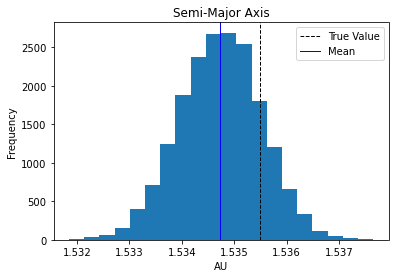

Semi-Major Axis: 
	mean: 1.534731991304897
	error: 0.05008997964107639
	standard deviation of mean: 0.0007785654008155097



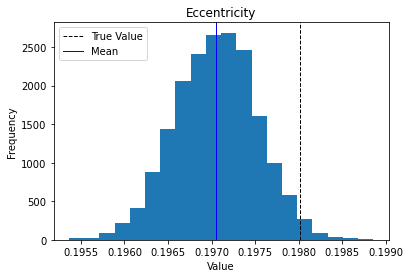

Eccentricity: 
	mean: 0.19705238633835584
	error: 0.48521311747375534
	standard deviation of mean: 0.00047053728078456117



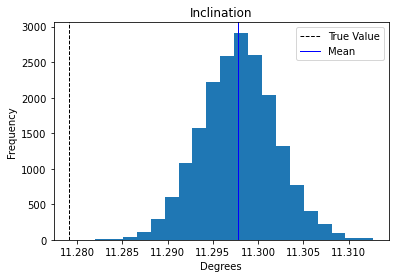

Inclination: 
	mean: 11.29780252231807
	error: 0.1659820462762092
	standard deviation of mean: 0.004145148692672203



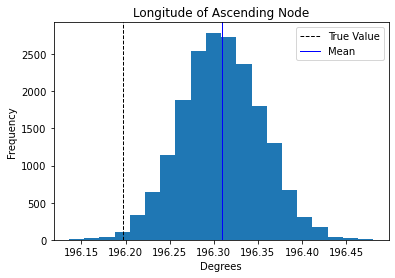

Longitude of Ascending Node: 
	mean: 196.30895432269787
	error: 0.05674036249242993
	standard deviation of mean: 0.045571254479176086



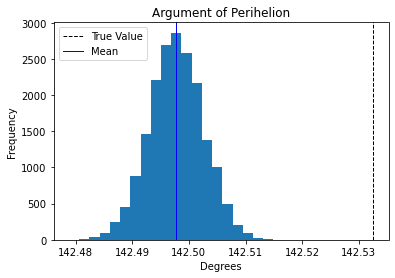

Argument of Perihelion: 
	mean: 142.49776921416938
	error: 0.024404681785055705
	standard deviation of mean: 0.004784738386216762



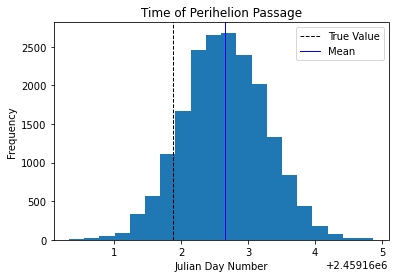

Time of Perihelion Passage: 
	mean: 2459162.649345345
	error: 3.1376080011530095e-05
	standard deviation of mean: 0.6122154129818305



In [54]:
def RunCompleteOD(iterations:int, inputFile:str, fitsFiles:list, sunFile:str, dates:list, results:list):
    # generate orbital elements
    data=Data()
    od=OD(inputFile)
    od.MoG(selDate=dates)
    
    # determine error
    a,e,i,o,w,m,T = results
    od.getError([e,0,i,o,w,T,0,0,0,a])
    od.exportResults(2459784.7916667, "July 24, 2022 7:00 UT", "SoongODResults.txt") 
    
    # Monte Carlo
    results = [a,e,i,o,w,T] 
    od.monteCarlo(iterations, fitsFiles, "SoongMonteCarloOutput.txt", results, selDate=dates)
    
    # generate the ephemeris
    od.genEphemeris(sunFile, "SoongGeneratedEphemeris.txt")

iterations=10000 # Monte Carlo Iterations
inputFile="/home/soonali/Desktop/SSP2022/SoongInput.txt" # Input File path
sunFile="/home/soonali/Desktop/SSP2022/1999GJ2SunPos.txt" # Path for file containing times and sun positions for ephemeris generation
fitsFiles=["/home/soonali/Desktop/SSP2022/0628.fits", 
           "/home/soonali/Desktop/SSP2022/0712.fits", 
           "/home/soonali/Desktop/SSP2022/0714.fits"] # Fits Files path
dates=['2022-06-28 04:33:44.089','2022-07-12 04:16:40.826','2022-07-14 04:41:39.025'] # Dates selected
results=[1.535501123505049E+00, 1.980131722243141E-01, 1.127908127242095E+01, 
         1.961976310756240E+02, 1.425325538303718E+02, 3.163937598615976E+02, 
         2459856.859881772194] # [a,e,i,o,w,m,T], results from JPL horizons for 2022-07-12 04:16:40.826

RunCompleteOD(iterations, inputFile, sunFile, fitsFiles, dates, results)

In [57]:
def GenerateEphemeris(inputFile:str, ODdates:list, sunFile:str):
    """ 
        Outputs ephemeris to file.
        Args: 
            inputFile (str): path for file containing observations to determine orbital elements
            ODdates (list): list of dates for orbital elements determination
            sunFile (str): path for file containing times and sun positions for ephemeris generation
        Returns:
            None
    """
    
    # calculating orbital elements
    data=Data()
    od=OD(inputFile)
    od.MoG(selDate=dates)
    
    # generate ephemeris
    od.genEphemeris(sunFile, "GeneratedEphemeris.txt")
    
    print("Finished generating ephemeris")

inputFile = "/home/soonali/Desktop/SSP2022/SoongInput.txt"
sunFile = "/home/soonali/Desktop/SSP2022/1999GJ2SunPos.txt"
ODdates = ['2022-06-28 04:33:44.089','2022-07-12 04:16:40.826','2022-07-14 04:41:39.025']
GenerateEphemeris(inputFile, ODdates, sunFile)

Finished generating ephemeris
